In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [4]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\jesse\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


In [5]:
transforms = transforms.ToTensor()

In [6]:
train_data = datasets.MNIST(root='./datasets', train=True, download=True, transform=transforms)

In [7]:
test_data = datasets.MNIST(root='./datasets', train=False, download=True, transform=transforms)

In [8]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./datasets
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [9]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: ./datasets
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [10]:
type(train_data)

torchvision.datasets.mnist.MNIST

In [11]:
image, label = train_data[0]

In [12]:
image.shape

torch.Size([1, 28, 28])

In [13]:
label

tensor(5)

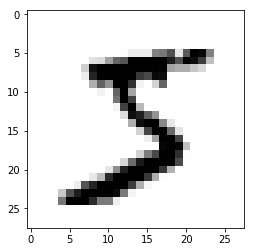

In [14]:
plt.imshow(image.reshape((28,28)), cmap='gist_yarg')

In [15]:
torch.manual_seed(101)

# 0 images, 1 images, ...
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)

test_loader = DataLoader(test_data, batch_size=500, shuffle=False)

In [16]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))

In [17]:
# FIRST BATCH
for images, labels in train_loader:
    break
    #60,000 / 100 per batch =  60 times

Labels:  [   7    2    3    5    8    5    3    6    9    9    1    3]


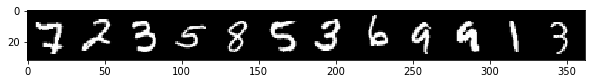

In [18]:
# Print the first 12 labels
print('Labels: ', labels[:12].numpy())

# Print the first 12 images
im = make_grid(images[:12], nrow=12)  # the default nrow is 8
plt.figure(figsize=(10,4))
# We need to transpose the images from CWH to WHC
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [19]:
class MultilayerPerceptron(nn.Module):

    def __init__(self, in_sz=784, out_sz=10, layers=[120, 84]):
        super().__init__()

        self.fc1 = nn.Linear(in_sz, layers[0])
        self.fc2 = nn.Linear(layers[0], layers[1])
        self.fc3 = nn.Linear(layers[1], out_sz)

    def forward(self, X):

        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)

        return F. log_softmax(X, dim=1) #Multiclass classification

In [20]:
torch.manual_seed(101)
model = MultilayerPerceptron()
model

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [21]:
# ANN ---> CNN
for param in model.parameters(): # ~105k parameters for 28 pixels, CNN is more efficient with more accuracy
    print(param.numel())

94080
120
10080
84
840
10


In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [23]:
images.shape # ----> [100, 784]. 100 layers of neurons for each pixel 28*28=784

torch.Size([100, 1, 28, 28])

In [24]:
images.view(100, -1).shape

torch.Size([100, 784])

In [25]:
import time
start_time = time.time()

# TRAINING

epochs = 10

#Trackers
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    for b, (X_train, y_train) in enumerate(train_loader):
        b +=1

        # 10 neurons
        y_pred = model(X_train.view(100, -1)) #The batch portion/new dimension is covered by the neural network base class.
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{100*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(100*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    with torch.no_grad():

        for b, (X_test, y_test) in enumerate(test_loader):

            y_val = model(X_test.view(500, -1))

            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted==y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

total_time = time.time()-start_time
print(f'Duration: {total_time/60} mins')


epoch:  0  batch:  200 [ 20000/60000]  loss: 0.23562379  accuracy:  83.245%
epoch:  0  batch:  400 [ 40000/60000]  loss: 0.35330707  accuracy:  87.532%
epoch:  0  batch:  600 [ 60000/60000]  loss: 0.13765770  accuracy:  89.582%
epoch:  1  batch:  200 [ 20000/60000]  loss: 0.24507995  accuracy:  94.880%
epoch:  1  batch:  400 [ 40000/60000]  loss: 0.14157324  accuracy:  95.105%
epoch:  1  batch:  600 [ 60000/60000]  loss: 0.07288369  accuracy:  95.368%
epoch:  2  batch:  200 [ 20000/60000]  loss: 0.08517582  accuracy:  96.610%
epoch:  2  batch:  400 [ 40000/60000]  loss: 0.06132581  accuracy:  96.698%
epoch:  2  batch:  600 [ 60000/60000]  loss: 0.06279158  accuracy:  96.750%
epoch:  3  batch:  200 [ 20000/60000]  loss: 0.11695743  accuracy:  97.630%
epoch:  3  batch:  400 [ 40000/60000]  loss: 0.05154384  accuracy:  97.487%
epoch:  3  batch:  600 [ 60000/60000]  loss: 0.03660450  accuracy:  97.513%
epoch:  4  batch:  200 [ 20000/60000]  loss: 0.10782868  accuracy:  98.125%
epoch:  4  b

In [27]:
train_acc = [t/600 for t in train_correct]

In [28]:
test_acc = [t/600 for t in test_correct]

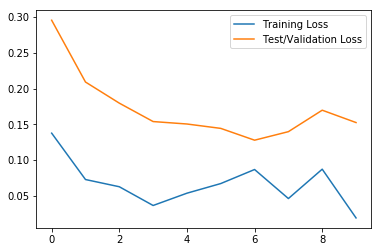

In [31]:
with torch.no_grad():
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Test/Validation Loss')
    plt.legend()

In [32]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [33]:
with torch.no_grad():
    correct = 0

    for X_test, y_test in test_load_all:
        y_val = model(X_test.view(len(X_test), -1))
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum()

In [34]:
100*correct.item()/len(test_data)

97.72

In [35]:
confusion_matrix(predicted.view(-1), y_test.view(-1))

array([[ 971,    0,    4,    0,    1,    2,    5,    2,    5,    1],
       [   0, 1124,    3,    0,    0,    0,    3,    7,    0,    3],
       [   1,    3, 1003,    2,    1,    0,    1,    9,    4,    0],
       [   2,    3,    5,  991,    0,   12,    1,    1,    4,    3],
       [   1,    0,    2,    0,  965,    3,    2,    3,    5,    8],
       [   0,    0,    0,    4,    0,  861,    3,    1,    2,    3],
       [   1,    1,    1,    0,    5,    5,  942,    0,    1,    0],
       [   1,    0,    4,    4,    0,    0,    0,  981,    3,    0],
       [   2,    4,    9,    3,    0,    7,    1,    2,  946,    3],
       [   1,    0,    1,    6,   10,    2,    0,   22,    4,  988]],
      dtype=int64)